# RTF Model for predicting racket Type with Peaks - Vibrations

Import

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

ReadCsv function

Colonnes du fichier P1_RB_4_C_1.csv : (2401, 1)


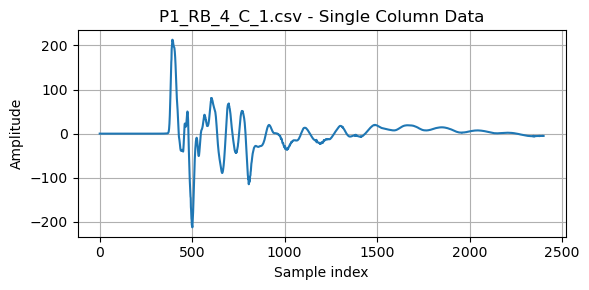

Colonnes du fichier P1_RB_3_S_2.csv : (2401, 1)


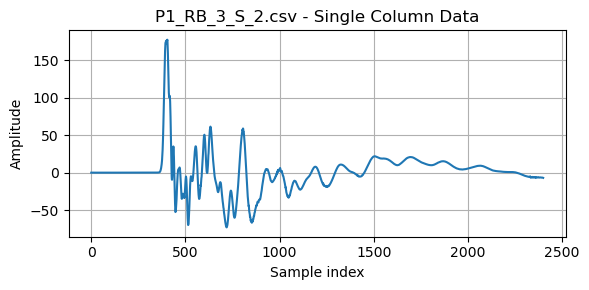

In [2]:
def readCsvFolder(folderPath):
    fileFolder = []
    files = []
    for filepath in glob.glob(os.path.join(folderPath, '*.csv')):
        try:
            data = pd.read_csv(filepath, header=None)  # On suppose pas d'en-têtes
            fileFolder.append(data)
            files.append(os.path.basename(filepath))
        except Exception as e:
            print(f"Erreur lors de la lecture de {filepath} : {e}")
    return fileFolder, files

# Lecture des fichiers
csv_data_list, filenames = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P1_clean/RB")

# Affichage
for i,csv_data in enumerate(csv_data_list[:2]):
    print(f"Colonnes du fichier {filenames[i]} :",csv_data.shape)

    plt.figure(figsize=(6, 3))
    if csv_data.shape[1] >= 2:
        time_axis = range(len(csv_data.iloc[:, 1]))  # Pas de vraie échelle de temps si on ne l'a pas
        plt.plot(time_axis, csv_data.iloc[:, 1], label="Amplitude")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
        plt.title(f"{filenames[i]} - Channel 1")
    else:
        plt.plot(csv_data.iloc[:, 0])
        plt.title(f"{filenames[i]} - Single Column Data")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Spectrum

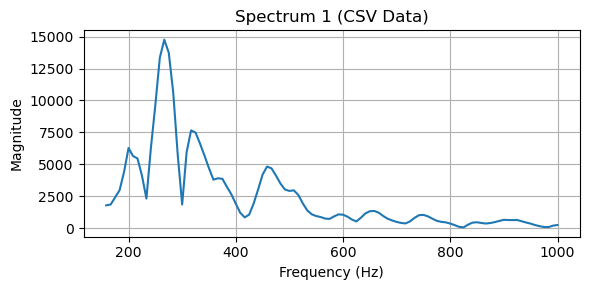

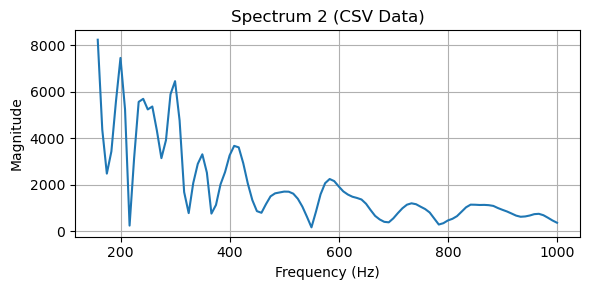

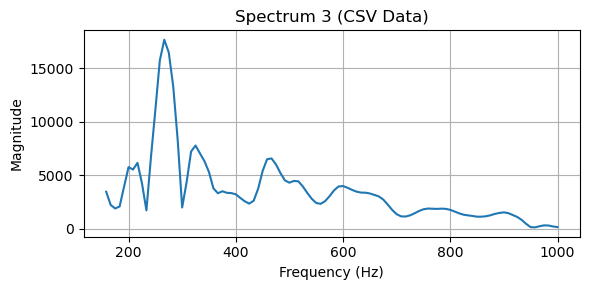

In [3]:
def spectrumFromCsv(csv_data, sample_rate):
    """Calcule le spectre à partir d'un signal CSV"""
    signal = csv_data.iloc[:, 0].values  # extrait la colonne souhaitée
    spectrum = fft(signal)
    magnitude = abs(spectrum[:len(spectrum) // 2])
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)[:len(spectrum) // 2]
    return freqs, magnitude

sample_rate = 20000

spectrumVect = []

for csv_data in csv_data_list:
    freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)
    # Filtrage de la bande [150 Hz, 1000 Hz]
    band_mask = (freqs >= 150) & (freqs <= 1000)
    filtered_freqs = freqs[band_mask]
    filtered_spectrum = spectrum[band_mask]
    spectrumVect.append((filtered_freqs, filtered_spectrum))


# Visualisation des spectres pour les données CSV
for idx, (freqs, spectrum) in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs, spectrum)
    plt.title(f"Spectrum {idx + 1} (CSV Data)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Extract each peak and store

In [4]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values


# Fonction pour lire les fichiers d'un dossier donné
def lire_fichiers_dossier(dossier):
    if os.path.exists(dossier):  # Vérifier si le dossier existe
        return readCsvFolder(dossier)
    else:
        print(f"Dossier introuvable : {dossier}")
        return [], [], []  # Retourne des listes vides si le dossier n'existe pas


## Main

In [5]:
# Liste des types de raquettes et zones
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
racket_ages = {"P1":1, "P2":2, "P3":3}

allCsvFile=[]
allCsvFileLabel=[]
allCsvFileRB=[]
allCsvFileRO=[]
allCsvFileRR=[]
allCsvFileRV=[]
results = []


for ages in racket_ages:
    fileFolderRB,filesRB = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RB")
    if ages == "P1":
        fileFolderRB = [df for df, path in zip(fileFolderRB, filesRB) if "_C." in os.path.basename(path)]
    allCsvFileRB.extend(fileFolderRB)
    
    fileFolderRO,filesRO = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RO")
    if ages == "P1":
        fileFolderRO = [df for df, path in zip(fileFolderRO, filesRO) if "_C." in os.path.basename(path)]
    allCsvFileRO.extend(fileFolderRO)

    fileFolderRR,filesRR = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RR")
    if ages == "P1":
        fileFolderRR = [df for df, path in zip(fileFolderRR, filesRR) if "_C." in os.path.basename(path)]
    allCsvFileRR.extend(fileFolderRR)

    fileFolderRV,filesRV = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/"+ages+"_clean/RV")
    if ages == "P1":
        fileFolderRV = [df for df, path in zip(fileFolderRV, filesRV) if "_C." in os.path.basename(path)]
    allCsvFileRV.extend(fileFolderRV)


# Find the minimum length among the three lists
min_len = min(len(allCsvFileRB), len(allCsvFileRO), len(allCsvFileRR), len(allCsvFileRV))


# Reduce each list to the minimum length
allCsvFileRB = allCsvFileRB[:min_len]
allCsvFileRO = allCsvFileRO[:min_len]
allCsvFileRR = allCsvFileRR[:min_len]
allCsvFileRV = allCsvFileRV[:min_len]

print("Len(allCsvFileRB)",len(allCsvFileRB),"Len(allCsvFileRO)",len(allCsvFileRO),"Len(allCsvFileRR)",len(allCsvFileRR),"Len(allCsvFileRV)",len(allCsvFileRV))


# print(len(sampleRateFolderP1))

for csvFile in allCsvFileRB:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RB")
for csvFile in allCsvFileRO:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RO")
for csvFile in allCsvFileRR:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RR")
for csvFile in allCsvFileRV:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("RV")
    
for n_peak in range(10,101,5):
    bestPeakHZAllCsvFile = []
    bestPeakAmplitudeAllCsvFile = []

    for csvFile in allCsvFile:
        # Compute the spectrum using FFT
        freqs, spectrum = spectrumFromCsv(csvFile, sample_rate)
        band_mask = (freqs >= 150) & (freqs <= 1000)
        filtered_spectrum = spectrum[band_mask]
        # Extract peaks from the spectrum
        peaks_HZ, peak_Amplitude = extractNPeak(n_peak, filtered_spectrum)
        bestPeakHZAllCsvFile.append(peaks_HZ)
        bestPeakAmplitudeAllCsvFile.append(peak_Amplitude)

    

    max_amp = max(np.max(amp) for amp in bestPeakAmplitudeAllCsvFile)
    bestPeakAmplitudeAllCsvFile = [amp / max_amp for amp in bestPeakAmplitudeAllCsvFile]

    # Combine features into X
    X = np.hstack([np.array(bestPeakHZAllCsvFile), np.array(bestPeakAmplitudeAllCsvFile)])

    # Encode string labels into integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(allCsvFileLabel)

    # Diviser les données en ensembles d'entraînement et de test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Définir les bonnes valeurs trouvé
    n_estimators_range = [10, 50, 100]
    max_depth_range = [None, 10, 20, 30]
    min_samples_split_range = [2, 5, 10]

    # Tester toutes les combinaisons d'hyperparamètres
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                y_train_pred = rf.predict(X_train)

                results.append({
                    'n_peak': n_peak,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'accuracy_train': accuracy_score(y_train, y_train_pred),
                    'accuracy_test': accuracy_score(y_test, y_pred)
                })
                
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("V_RTF_Raquette_P1.P2.P3_Peaks2.xlsx", index=False)

print("Results have been saved to 'RTF_Raquette_P1.P2.P3_Peaks.xlsx'.")

# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

    
    

Len(allCsvFileRB) 134 Len(allCsvFileRO) 134 Len(allCsvFileRR) 134 Len(allCsvFileRV) 134
Results have been saved to 'RTF_Raquette_P1.P2.P3_Peaks.xlsx'.
     n_peak  n_estimators  max_depth  min_samples_split  accuracy_train  \
683     100           100       30.0                 10             1.0   
627      95            50       10.0                  2             1.0   
597      90            50       30.0                  2             1.0   
600      90           100        NaN                  2             1.0   
601      90           100        NaN                  5             1.0   
..      ...           ...        ...                ...             ...   
216      40            10        NaN                  2             1.0   
233      40            50       10.0                 10             1.0   
225      40            10       30.0                  2             1.0   
222      40            10       20.0                  2             1.0   
219      40            1

Extract peaks

In [16]:
bestPeakHZAllCsvFile = []
bestPeakAmplitudeAllCsvFile = []
n_peak = 25

for csvFile in allCsvFile:
    # Compute the spectrum using FFT
    freqs, spectrum = spectrumFromCsv(csvFile, sample_rate)

    # Extract peaks from the spectrum
    peaks_HZ, peak_Amplitude = extractNPeak(n_peak, spectrum)
    bestPeakHZAllCsvFile.append(peaks_HZ)
    bestPeakAmplitudeAllCsvFile.append(peak_Amplitude)

    # Normaliser les amplitudes
    bestPeakAmplitudeAllCsvFile = [amp / np.max(amp) for amp in bestPeakAmplitudeAllCsvFile]

In [17]:
# Combine features into X
X = np.hstack([np.array(bestPeakHZAllCsvFile), np.array(bestPeakAmplitudeAllCsvFile)])

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allCsvFileLabel)

# Diviser les données en ensembles d'entraînement et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
# Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

results = []

# Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_train_pred = rf.predict(X_train)

            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_score(y_train, y_train_pred),
                'accuracy_test': accuracy_score(y_test, y_pred)
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
# results_df.to_excel("RTF_Raquette_P1.P2.P3_Peaks.xlsx", index=False)

# print("Results have been saved to 'RTF_Raquette_P1.P2.P3_Peaks.xlsx'.")

# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
4             10       10.0                  5        0.784874       0.758389
5             10       10.0                 10        0.788235       0.758389
0             10        NaN                  2        0.789916       0.751678
27           100       10.0                  2        0.791597       0.751678
21            50       30.0                  2        0.791597       0.751678
22            50       30.0                  5        0.791597       0.751678
23            50       30.0                 10        0.789916       0.751678
24           100        NaN                  2        0.791597       0.751678
25           100        NaN                  5        0.791597       0.751678
26           100        NaN                 10        0.791597       0.751678
29           100       10.0                 10        0.791597       0.751678
28           100       10.0                  5        0.791597  

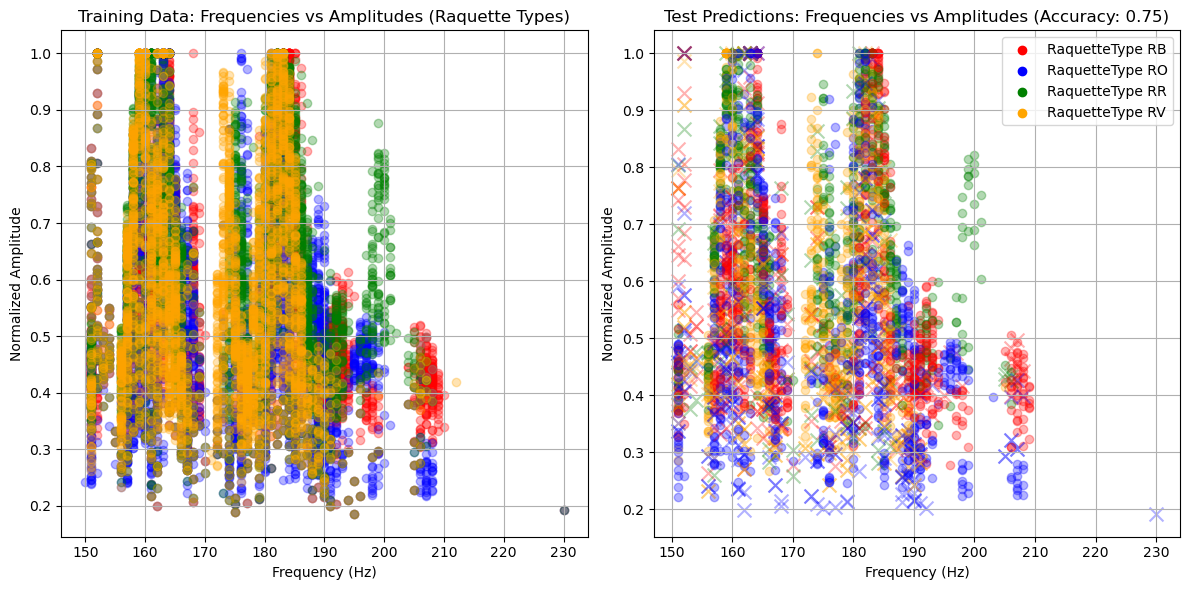

In [19]:
# Define a color map for the labels
colors = ['red', 'blue', 'green', 'orange']
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
label_names = list(raquetteTypeList.keys())

# Create a scatter plot for the training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # First subplot for training data
for label_idx, label_name in enumerate(label_names):
    # Filter data points for the current label
    label_data = X_train[y_train == label_idx]
    for sample in label_data:
        # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
        frequencies = sample[:n_peak] + 150
        amplitudes = sample[n_peak:]
        mask = frequencies <= 550
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[label_idx], alpha=0.3)

plt.title("Training Data: Frequencies vs Amplitudes (Raquette Types)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

# Create a scatter plot for the test data with predictions
plt.subplot(1, 2, 2) # Second subplot for test data with predictions
y_pred = rf.predict(X_test) # Get predictions for test data

for i, sample in enumerate(X_test):
    true_label = y_test[i]
    pred_label = y_pred[i]

    # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
    frequencies = sample[:n_peak] + 150
    amplitudes = sample[n_peak:]
    mask = frequencies <= 550

    # Plot with solid color if prediction is correct, otherwise use a different marker
    if true_label == pred_label:
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], alpha=0.3)
    else:
        # Use 'x' marker for incorrect predictions
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], marker='x', s=100, alpha=0.3)

# Add a legend
for label_idx, label_name in enumerate(label_names):
    plt.scatter([], [], color=colors[label_idx], label=f"RaquetteType {label_name}")

plt.legend()
plt.title(f"Test Predictions: Frequencies vs Amplitudes (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

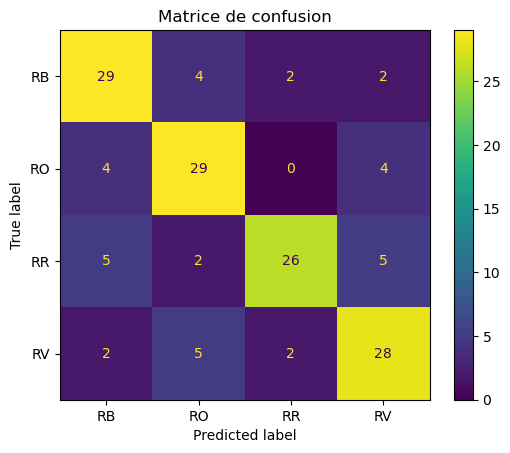

In [20]:
# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()